In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from datetime import date
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# read the dataset
df = pd.read_excel('Data_forecast_covid2020.xlsx')

In [3]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

In [4]:
df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')

C:\Users\HP\AppData\Local\Temp\ipykernel_8640\2680437410.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')


In [5]:
df.index = df.Tanggal
df.head()

,Tanggal,nama_kecamatan,POSITIF
Tanggal,,,
2020-03-25,2020-03-25,CENGKARENG,0
2020-03-25,2020-03-25,CENGKARENG,3
2020-03-25,2020-03-25,CENGKARENG,2
2020-03-25,2020-03-25,CENGKARENG,1
2020-03-25,2020-03-25,CENGKARENG,0


# Resample to daily period

In [6]:
df_day = df.resample('D').mean()
missing_replacement = df['2020-03-25': '2020-03-28'].mean(numeric_only=True)
df_day.loc['2020-03-26'] = missing_replacement
df_day.loc['2020-03-27'] = missing_replacement
df_day.loc['2020-03-28'] = missing_replacement

df_day.isnull().sum()

POSITIF    0
dtype: int64

# Timeseries Visualization

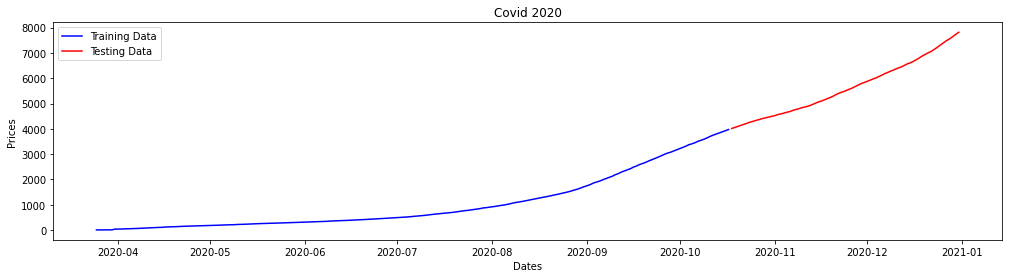

In [7]:
df_train = df_day.loc['2020-01-01':'2020-10-17']
df_test = df_day.loc['2020-10-18':]

plt.figure(figsize=(17, 4))
plt.title('Covid 2020')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.POSITIF, 'blue', label='Training Data')
plt.plot(df_test.POSITIF, 'red', label='Testing Data')

plt.legend()

y_train = df_train.POSITIF.values
y_test = df_test.POSITIF.values

In [8]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print('Estimated differencing term:', n_diffs)

auto = pm.auto_arima(
    y_train, d=n_diffs, 
    seasonal=True, stepwise=True,
    suppress_warnings=True, error_action="ignore", 
    max_p=6, max_order=None, trace=True
)

Estimated differencing term: 2
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1249.957, Time=0.85 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1361.880, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1299.579, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1256.602, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1248.202, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1253.527, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1254.987, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1249.915, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=1252.993, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1254.115, Time=0.08 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1251.455, Time=0.25 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1255.109, Time=0.26 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 2.150 seconds


# Model Evaluation

In [9]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

y_predict = []
y_confidence = []

for i, new_ob in enumerate(y_test):
    fc, conf = forecast_one_step()
    y_predict.append(fc)
    y_confidence.append(conf)
    
    print(i, fc, new_ob, abs(fc - new_ob))

    model.update(new_ob)

print('Mean squared error:', mean_squared_error(y_test, y_predict, squared=False))
print('Root Mean squared error:', mean_squared_error(y_test, y_predict))
print('R-Squared', r2_score(y_test, y_predict))

0 4019.273604240095 4013.9148936170213 5.3587106230738755
1 4059.1704348114918 4053.31914893617 5.851285875321537
2 4096.86954184087 4094.340425531915 2.529116308954599
3 4136.57292663363 4136.893617021276 0.3206903876462093
4 4178.305368579853 4178.978723404255 0.6733548244019403
5 4219.812006325464 4219.489361702128 0.322644623335691
6 4259.715780244296 4264.68085106383 4.9650708195340485
7 4305.281535865936 4297.489361702128 7.79217416380834
8 4336.605949961917 4336.04255319149 0.5633967704270617
9 4374.557651610071 4369.276595744681 5.281055865390044
10 4406.504510952948 4405.191489361702 1.3130215912460699
11 4441.533674959443 4435.531914893617 6.001760065825692
12 4470.266242636778 4461.574468085107 8.691774551671188
13 4493.9349203393895 4493.489361702128 0.44555863726145617
14 4524.6319670432 4519.36170212766 5.270264915540793
15 4548.5293610880335 4562.936170212766 14.406809124732717
16 4593.456081851115 4589.191489361702 4.2645924894131895
17 4618.694613720796 4622.1276595744

# Visualize the prediction values

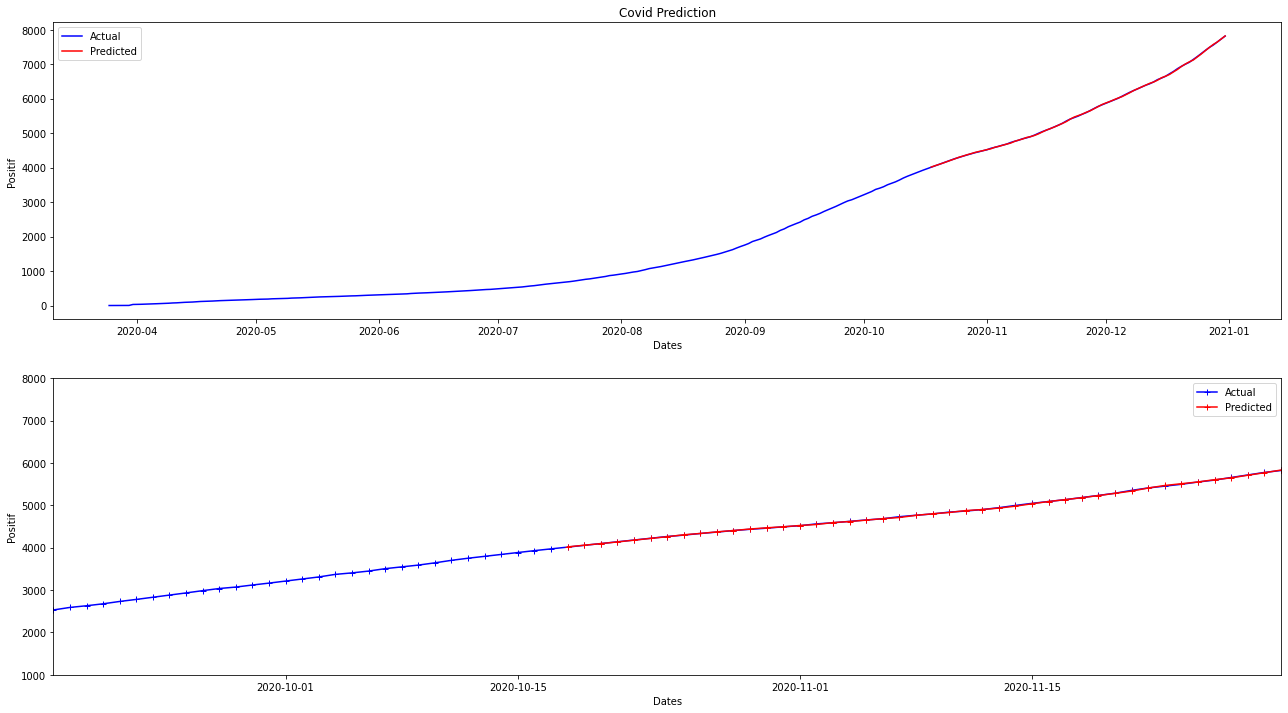

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(22, 12))

axes[0].plot(df_day.index, df_day.POSITIF, color='blue', label='Actual')
axes[0].plot(df_test.index, y_predict, color='red', label='Predicted')
#axes[0].plot([date(2020, 10, 17), date(2020, 10, 17)], [0, 7500], 'black')

axes[0].set_title('Covid Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Positif')
axes[0].legend()

axes[1].plot(df_day.index, df_day.POSITIF, ls='-', marker='+', color='blue', label='Actual')
axes[1].plot(df_test.index, y_predict, ls='-', marker='+', color='red', label='Predicted')

axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Positif')
axes[1].set_xlim(date(2020, 9, 17), date(2020, 11, 30))
axes[1].set_ylim(1000, 8000)
axes[1].legend()

plt.savefig('ARIMACov2020.jpg',  dpi=300, bbox_inches='tight')
plt.show()